In [1]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.utils import pad_sequences

In [2]:
df=pd.read_csv('../data/labeled_data.csv')
df=df.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1)

In [3]:
df.head()

df['class']=df['class'].replace({0:1})

<Axes: xlabel='class', ylabel='count'>

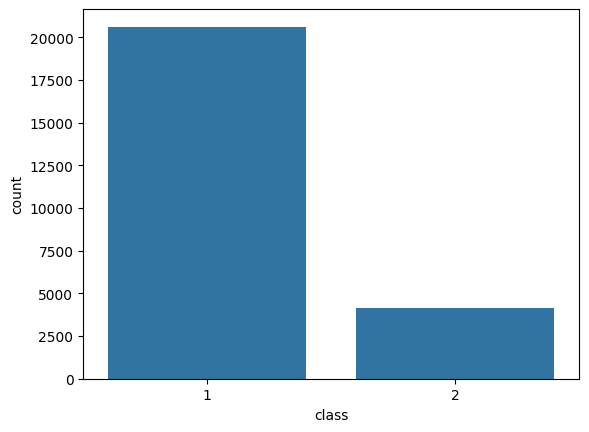

In [4]:
sns.countplot(x='class',data=df)

class 0: hate, class 1: abusive, and class 2: no hate.

In [5]:
df.isna().sum()

class    0
tweet    0
dtype: int64

In [6]:
# df["class"].replace({0:1},inplace=True)

<Axes: xlabel='class', ylabel='count'>

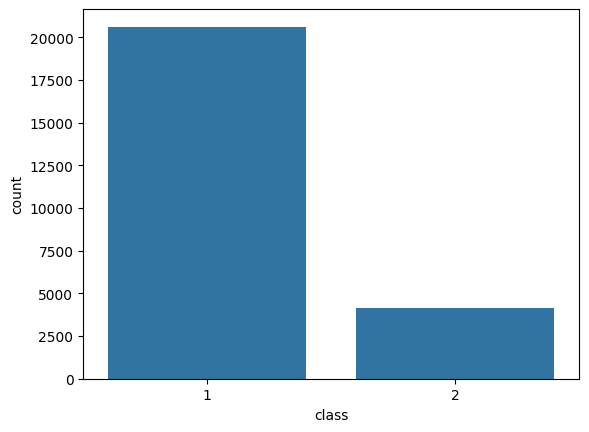

In [7]:
sns.countplot(x='class',data=df)

#### 1 for hate 2 for no hate 

In [8]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [9]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [10]:
df.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:

# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [12]:
df

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,1,rt urkindofbrand dawg rt you ever fuck a bit...
3,1,rt cganderson vivabased she look like a trann...
4,1,rt shenikaroberts the shit you hear about me ...
...,...,...
24778,1,yous a muthafin lie coreyemanuel right his t...
24779,2,youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you li youu got w...


In [13]:
X = df['tweet']
y = df['class']

In [14]:
X

0         rt mayasolovely as a woman you shouldnt compl...
1         rt  boy dats coldtyga dwn bad for cuffin dat ...
2         rt urkindofbrand dawg rt  you ever fuck a bit...
3         rt cganderson vivabased she look like a trann...
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous a muthafin lie   coreyemanuel right his t...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like i aint fu...
24781    youu got wild bitches tellin you li youu got w...
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [15]:
y

0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64

In [16]:
y.nunique()

2

In [17]:
# Let's split the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42,test_size=.2)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

19826 19826
4957 4957


In [18]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [19]:
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

26752

In [21]:
len(X_train)

19826

In [22]:
# find out max_len

max_len=max(len(seq)for seq in X_train)
max_len

1089

In [ ]:
X_train=pad_sequences(X_train,padding='pre',maxlen=max_len)
X_test=pad_sequences(X_test,padding='pre',maxlen=max_len)

In [ ]:
y_test=to_categorical(y_test,num_classes=3)
y_train=to_categorical(y_train,num_classes=3)

In [ ]:
y_test

In [ ]:
y_test.shape

In [ ]:
model=Sequential([
    Embedding(50000,100,input_length=max_len),
    SpatialDropout1D(.3),
    LSTM(100,dropout=.2,return_sequences=True),
    # SpatialDropout1D(.2),
    LSTM(128,dropout=.3),
    Dense(3,activation='softmax')

])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,batch_size=128,epochs = 1,
                   validation_data=(X_test,y_test))

In [ ]:
import pickle
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save("models/model.keras")

In [130]:
import keras
import pickle
import re
import string

load_model=keras.models.load_model("models/model.keras")
with open('models/tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [132]:
# Let's test our model on custom data.
test = '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit'

def clean_text(text):
    print("Original text:", text)
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print("Text after regex:", text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    print("Cleaned text:", text)
    return text

test = 'i love this movie'
test_cleaned = clean_text(test)
print("Cleaned test:", test_cleaned)

# Tokenize and pad the sequence
seq = load_tokenizer.texts_to_sequences([test_cleaned])
padded = pad_sequences(seq, maxlen=300)
print("Padded sequence:", padded)

# Predict using the loaded model
pred = load_model.predict(padded)
print("Prediction array:", pred)

# Get the first element of the prediction array
pred_value = pred[0][0]
print("Prediction value:", pred_value)

# Print result based on prediction
if pred_value < 0.5:
    print("no hate")
else:
    print("hate and abusive")

     

Original text: i love this movie
Text after regex: i love this movie
Cleaned text: love movi
Cleaned test: love movi
Padded sequence: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  